In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from umap import UMAP
from sklearn.decomposition import PCA

/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
mean_df = pd.read_csv("mixture_rdkit_mean_definitions_clean.csv")
pna_df = pd.read_csv("mixture_rdkit_definitions_clean.csv")
mix_df = pd.read_csv("mixtures_combined.csv")
smi_df = pd.read_csv("mixture_smi_definitions_clean.csv")

In [40]:
smi_df['length'] = smi_df.apply(lambda row: len(row[2:].dropna()), axis=1)

# Figure 2

In [41]:
def get_umap(df, metric="euclidean", title_name=""):
    umap_model = UMAP(metric = "jaccard", densmap=True, random_state=42, low_memory = False)
    X_umap = umap_model.fit_transform(list(df[df.columns[3:]].values))
    df["UMAP_0"], df["UMAP_1"] = X_umap[:,0], X_umap[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="UMAP_0", y="UMAP_1", data=df, hue='length', palette='viridis', ax=ax, s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df

def get_pca(df, title_name=""):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(list(df[df.columns[3:]].values))
    df["PCA_0"], df["PCA_1"] = X_pca[:,0], X_pca[:,1]
    fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)
    g = sns.scatterplot(x="PCA_0", y="PCA_1", data=df, ax=ax, hue='length', palette='viridis', s=12, alpha=0.5)
    norm = plt.Normalize(df['length'].min(), df['length'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Number of Components")
    ax.set_xlabel(f"PC0 ({pca.explained_variance_ratio_[0]*100:.01f}%)")
    ax.set_ylabel(f"PC1 ({pca.explained_variance_ratio_[1]*100:.01f}%)")
    ax.set_title(title_name)
    ax.get_legend().remove()
    return df



In [43]:
pna_df

,Dataset,Mixture Label,length,0,1,2,3,4,5,6,...,794,795,796,797,798,799,UMAP_0,UMAP_1,PCA_0,PCA_1
0,Snitz 1,1,10,0.957874,0.014039,0.011828,0.017821,0.012443,0.010455,0.018601,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.289400,4.053301,4.945053,5.443691,-0.505114
1,Snitz 1,2,10,0.955011,0.018586,0.008236,0.014254,0.009872,0.007548,0.017269,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.214125,6.151059,2.970472,5.094244,-3.351377
2,Snitz 1,3,1,0.779125,0.005600,0.008611,0.019901,0.013371,0.010411,0.041993,...,0.9991,0.99972,0.950837,0.991969,0.934865,0.304671,-16.624107,1.518829,23.611556,10.244304
3,Snitz 1,4,20,0.944446,0.013755,0.007820,0.015712,0.011182,0.006509,0.018425,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.340924,1.048510,-0.302490,11.084236,-2.661145
4,Snitz 1,5,30,0.941628,0.017256,0.012197,0.024124,0.018669,0.010249,0.026607,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.212185,23.724186,20.320589,-19.531472,-1.281071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,Ravia 2,10,8,0.914559,0.017564,0.017186,0.022707,0.017080,0.016664,0.025681,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.161181,4.015260,15.946251,-1.570809,7.968513
776,Ravia 2,11,9,0.838744,0.052298,0.048263,0.076932,0.066255,0.046214,0.079506,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.211165,15.459800,4.413083,-2.991993,-8.195645
777,Ravia 2,12,9,0.964181,0.014004,0.012541,0.020707,0.014772,0.010779,0.021370,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.161181,13.822721,5.376896,-2.329026,-6.359463
778,Ravia 2,13,10,0.898442,0.028221,0.028216,0.039556,0.028555,0.031180,0.044347,...,0.9991,0.99972,0.950837,0.984909,0.934865,0.211165,4.484224,7.233764,3.637077,0.962734


/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/u/ctser/.conda/envs/ml/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


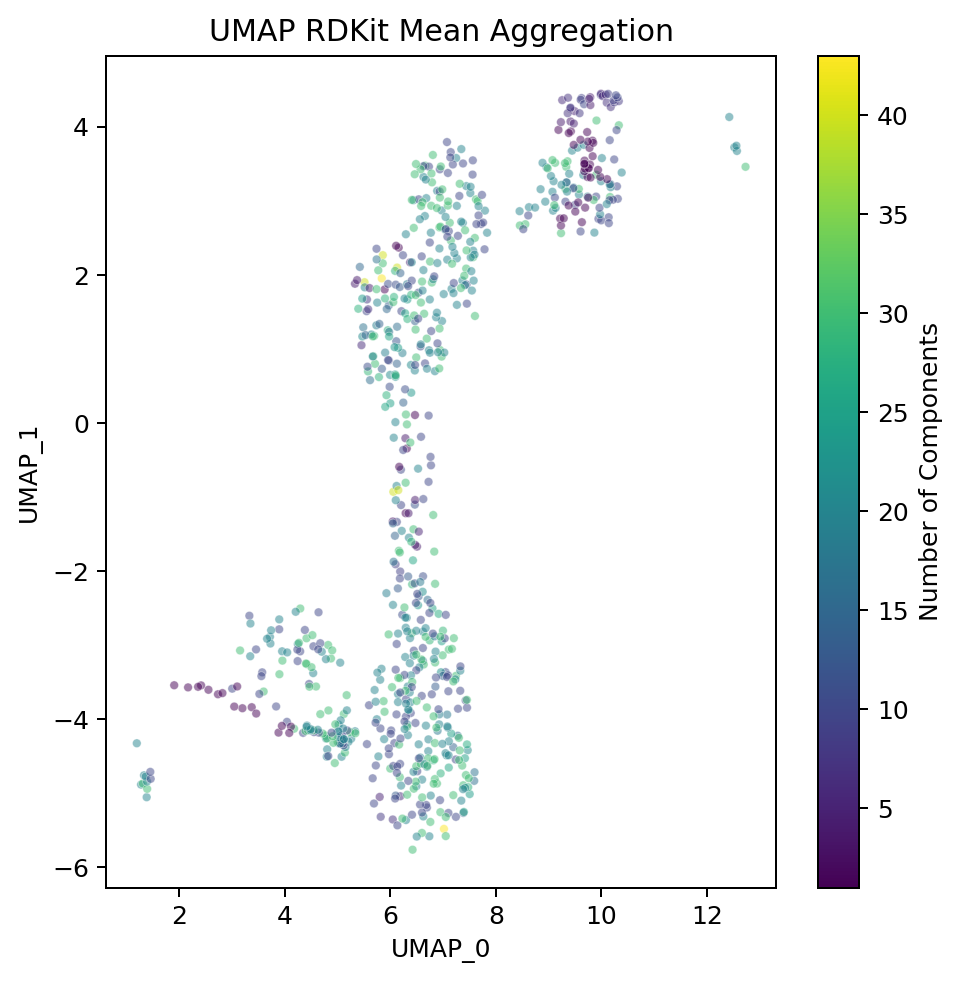

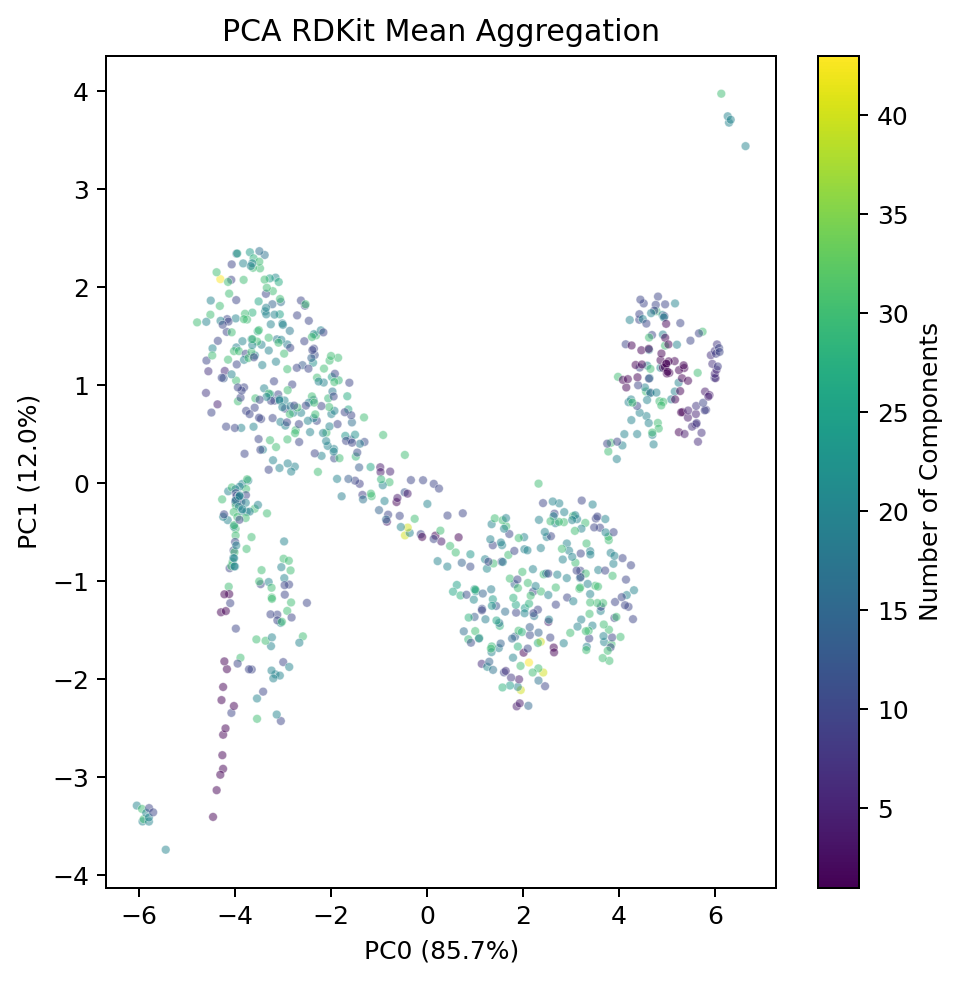

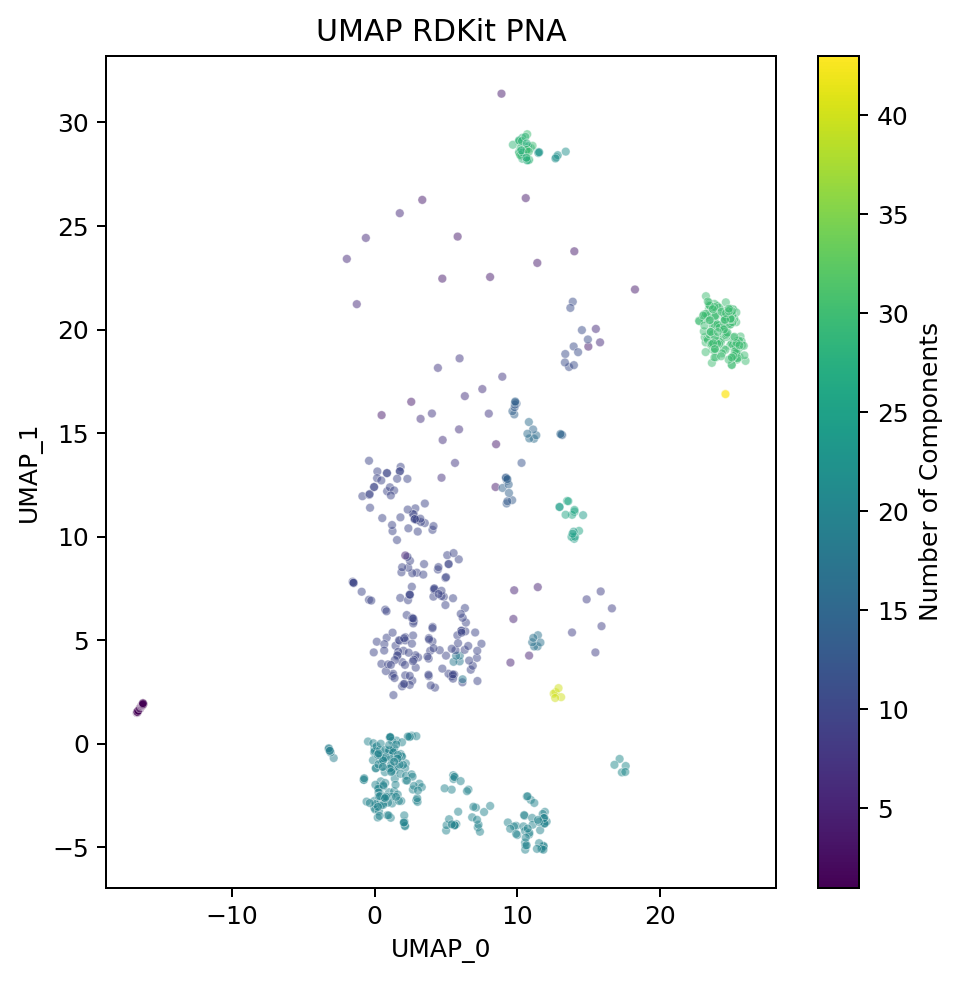

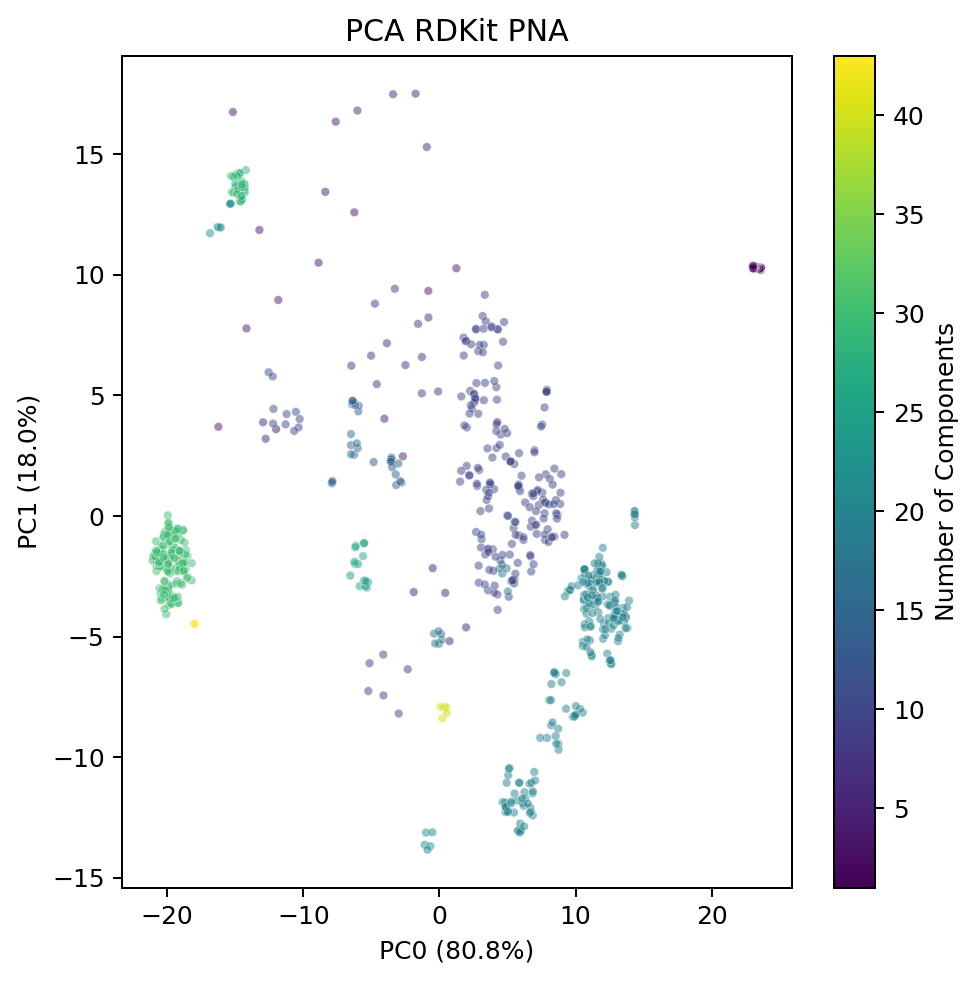

In [42]:
mean_df = pd.merge(smi_df[['Dataset', 'Mixture Label', 'length']], mean_df, on=["Dataset", "Mixture Label"], how='left')
mean_df = get_umap(mean_df, title_name="UMAP RDKit Mean Aggregation")
mean_df = get_pca(mean_df, title_name="PCA RDKit Mean Aggregation")

pna_df = pd.merge(smi_df[['Dataset', 'Mixture Label', 'length']], pna_df, on=["Dataset", "Mixture Label"], how='left')
pna_df = get_umap(pna_df, title_name="UMAP RDKit PNA")
pna_df = get_pca(pna_df, title_name="PCA RDKit PNA")



In [3]:
# Define mix1 as each row's Dataset and Mixture 1 value, and mix2 as Dataset and Mixture 2 value
# Get pna_df.columns[2:] for mix1 and mix2, and calculate the cosine distance between them

def get_aggregate(dataset, mixture_id, df):
    return df[(df["Dataset"] == dataset) & (df["Mixture Label"] == mixture_id)].iloc[0, 2:].to_numpy(dtype="float32")

def get_distance(dataset, mixture1, mixture2, df, distance='cosine'):
    mix1 = get_aggregate(dataset, mixture1, df)
    mix2 = get_aggregate(dataset, mixture2, df)
    return pdist([mix1, mix2], metric=distance)[0]

# Figure 6

In [44]:
mix_df["Mean Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], mean_df), axis=1)
mix_df["PNA Cosine Distance"] = mix_df.apply(lambda row: get_distance(row["Dataset"], row["Mixture 1"], row["Mixture 2"], pna_df), axis=1)

Text(0, 0.5, 'Perceptual Similarity')

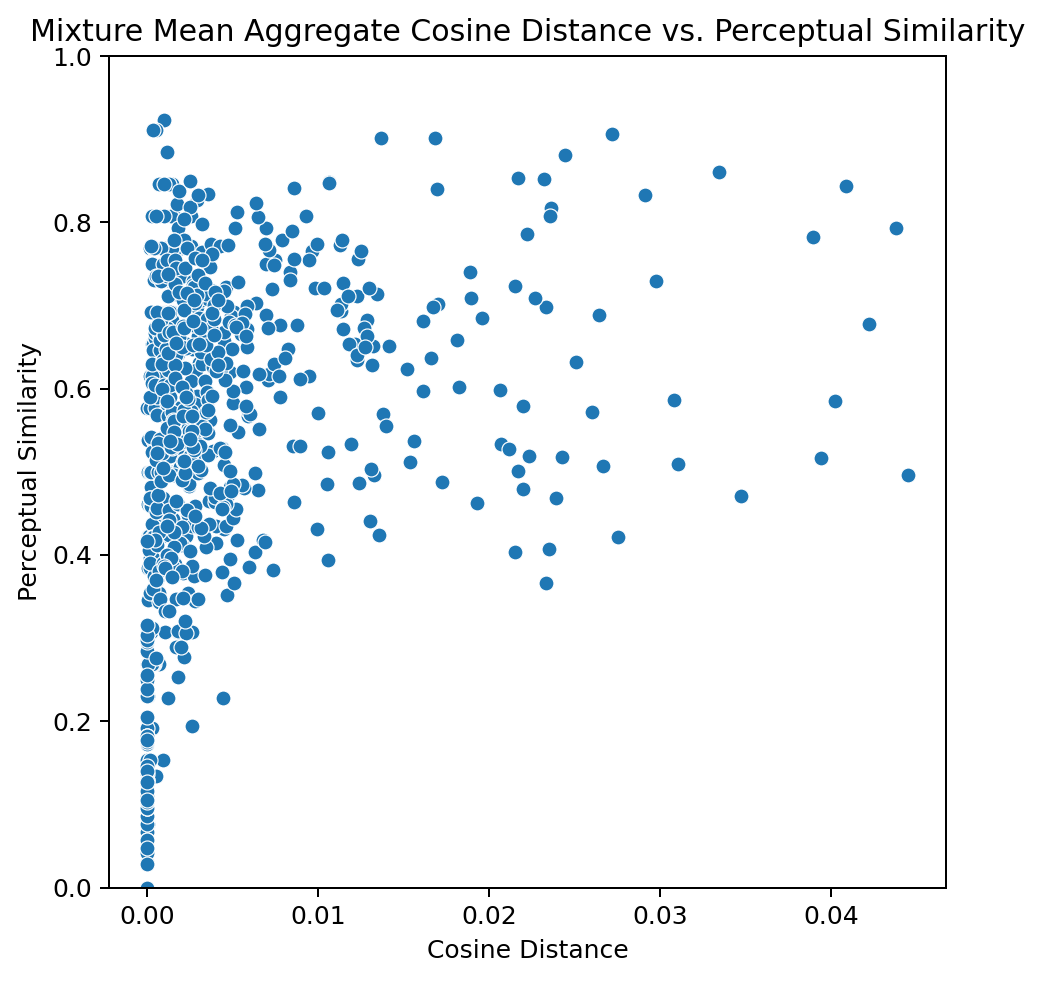

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="Mean Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture Mean Aggregate Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")

Text(0, 0.5, 'Perceptual Similarity')

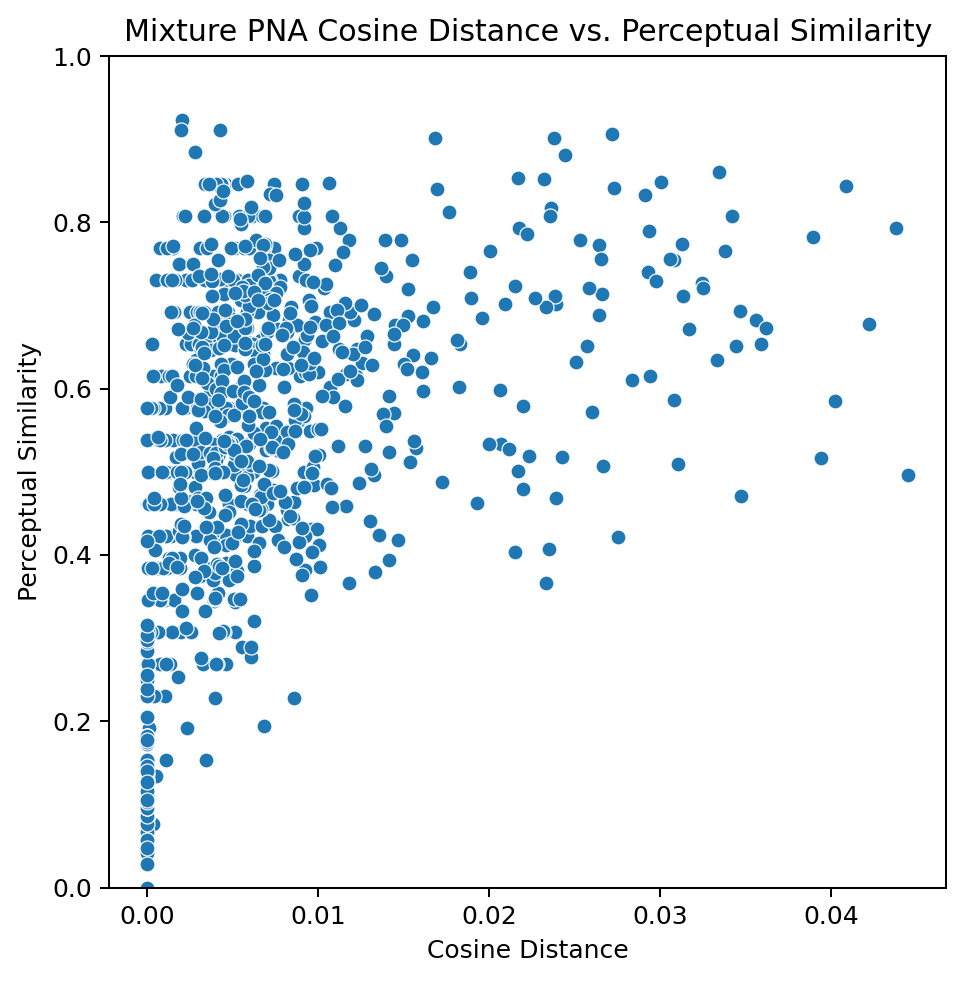

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=180)

g = sns.scatterplot(x="PNA Cosine Distance", y='Experimental Values', data=mix_df, ax=ax)

ax.set_ylim([0, 1])
ax.set_title("Mixture PNA Cosine Distance vs. Perceptual Similarity")
ax.set_xlabel("Cosine Distance")
ax.set_ylabel("Perceptual Similarity")